# Imports

In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

print("Pytorch:     ", torch.__version__, "( GPU:", torch.cuda.is_available(),")")
print("OpenAi Gym:  ", gym.__version__)

Pytorch:      1.2.0 ( GPU: False )
OpenAi Gym:   0.15.4


# Constants

In [2]:
# Environment: Cart Pole 
env_id = "LunarLander-v2"
env = gym.make(env_id)
SEE_ENV = False

# Model: Neural net
INPUT_STATE    = env.observation_space.shape[0]
NUM_LAYER_1    = 64
NUM_LAYER_2    = 64
OUTPUT_ACTIONS = env.action_space.n
DEVICE         = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Replay buffer memory
MAX_MEM    = 1000

# Training
NUM_ITERS    = 100000
UPDATE_MODEL = 500   # Update target model every 500 iters
BATH_SIZE    = 32
GAMMA        = 0.99

# Initial random exploration
EPS_START  = 1
EPS_END    = 0.01
EPS_DECAY  = NUM_ITERS / 20

# Run environment

In [3]:
if SEE_ENV:
    state = env.reset()

    for _ in range(1000):
        env.render()
        action            = env.action_space.sample() # Random actions
        state, _, done, _ = env.step(action)

        if done:
            state = env.reset()
    env.close()

# Replay Buffer

In [4]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.vstack(state), action, reward, np.vstack(next_state), done
    
    def __len__(self):
        return len(self.buffer)

# Agent (Neural Net)

In [5]:
class Agent(nn.Module):
    
    def __init__(self, num_inputs, num_layer1, num_layer2, num_actions):
        super(Agent, self).__init__()
        self.fc1  = nn.Linear(num_inputs, num_layer1)
        self.fc2  = nn.Linear(num_layer1, num_layer2)
        self.fc3  = nn.Linear(num_layer2, num_actions)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def act(self, stateNumpy, epsilon):
        if random.random() > epsilon:
            stateTensor   = torch.from_numpy(stateNumpy)
            actionsTensor = self.forward(stateTensor.float())
            return actionsTensor.argmax().item()
        
        else:
            action = random.randrange(env.action_space.n)
        return action

# Synchronize policy net and target net

In [6]:
def copyNet(source, target, way="hard", copy_perc=0.001): ## COPY_PERC a.k.a TAU
    
    if way=="hard":
        target.load_state_dict(source.state_dict())
    
    if way=="soft":
        # τ*θ_local + (1 - τ)*θ_target
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(COPY_PERC*source_param.data + (1.0-COPY_PERC)*target_param.data)

# Epsilon greedy exploration

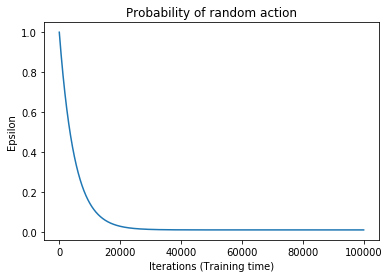

In [7]:
def prob_actionRandom(timestamp):
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * timestamp / EPS_DECAY)

plt.title('Probability of random action')
plt.xlabel('Iterations (Training time)')
plt.ylabel('Epsilon')
plt.plot([prob_actionRandom(i) for i in range(NUM_ITERS)]);

# Computing Temporal Difference Loss

In [8]:
def compute_td_loss(batch_size, gamma):
    
    # 1) Get batch from reply buffer memory
    state, action, reward, next_state, done = replay_mem.sample(batch_size)
    state      = torch.FloatTensor(state)      # [BS, INPUT_STATE]
    next_state = torch.FloatTensor(next_state) # [BS, INPUT_STATE]
    action     = torch.LongTensor(action)      # [BS]
    reward     = torch.FloatTensor(reward)     # [BS]
    done       = torch.FloatTensor(done)       # [BS]

    # 2) Compute Q values (NEW)
    q_values            = policy_net(state)      # [BS, OUTPUT_ACTIONS]
    next_q_values       = policy_net(next_state) # [BS, OUTPUT_ACTIONS]
    next_q_state_values = target_net(next_state) # [BS, OUTPUT_ACTIONS]
    
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1) # [BS]
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1) # [BS]
    expected_q_value = reward + gamma * next_q_value * (1 - done)         # [BS]
    
    # 3) Compute loss
    loss = (q_value - expected_q_value.data).pow(2).mean()
    
    # 4) Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [9]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    
    plt.subplot(131)
    plt.title('Iter %s. Reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    
    plt.subplot(132)
    plt.title('Loss')
    plt.plot(losses, color="green")
    
    plt.show()

# Main loop training

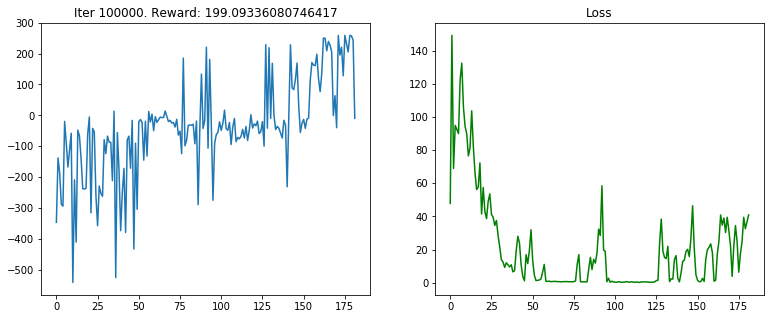

In [10]:
policy_net = Agent(INPUT_STATE, NUM_LAYER_1, NUM_LAYER_2, OUTPUT_ACTIONS).float().to(DEVICE) # Actor for compute rewards
target_net = Agent(INPUT_STATE, NUM_LAYER_1, NUM_LAYER_2, OUTPUT_ACTIONS).float().to(DEVICE) # Learn from actor episodes
copyNet(source=policy_net, target=target_net)
target_net.eval()

optimizer  = optim.Adam(policy_net.parameters())
replay_mem = ReplayBuffer(MAX_MEM)

# LOGGING
losses  = []; episode_losses = []
rewards = []; episode_reward = 0

state = env.reset()
for i in range(1, NUM_ITERS + 1):
    epsilon = prob_actionRandom(i)                           # Decrease the perecentage of random action
    action = policy_net.act(state, epsilon)                  # Select action from the agent
    next_state, reward, done, _ = env.step(action)           # Perform action in the enviroment
    replay_mem.push(state, action, reward, next_state, done) # Store the transition in memory
    state = next_state                                       # Define next state
    episode_reward += reward                                 # Store reward
    
    if done:
        state = env.reset()
        rewards.append(episode_reward)
        episode_reward = 0
        if len(episode_losses) > 0:
            losses.append(sum(episode_losses) / len(episode_losses) )
            episode_losses = []
        
    if len(replay_mem) > BATH_SIZE:
        loss = compute_td_loss(BATH_SIZE, GAMMA)
        episode_losses.append(loss.item())
        
    if i % UPDATE_MODEL == 0:
        copyNet(source=policy_net, target=target_net)
        
    if i%200 == 0:
        plot(i, rewards, losses)

# Test agent

In [11]:
state = env.reset()

for _ in range(10000):
    env.render()            
    action = target_net.act(state, epsilon=0)        # Select action from the agent
    next_state, reward, done, _ = env.step(action) # Perform action in the enviroment
    state = next_state                             # Define the next state
        
    if done:
        state = env.reset()
        
env.close()